We compare the magnitudes from the single-band vs band-merged catalogs

In [2]:
# Necessary imports ..

import matplotlib.pyplot as plt
from astropy.table import Table
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import urllib.request

from astropy.coordinates import SkyCoord
from astropy import units as u

from itertools import product
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
from scipy.stats import binned_statistic as bs



Grab image database to decipher the archive image name from the visit number 

In [5]:
image_database = 'imdb.fits'

if  image_database not in os.listdir(os.curdir) : 
    print('Downloading the image database catalog...')
    url = 'http://faun.rc.fas.harvard.edu/decaps/release/imdb.fits'
    urllib.request.urlretrieve(url, file_name)

# convert to an AstroPy table
imdb_hdu = fits.open(image_database)
imdb = Table(imdb_hdu[1].data)

Find out the single-band archive file for that visit :

In [7]:
# this can be used to find the name of single-band catalog for 
# the given visit to make it more automatic ...
visit = 611980
cat_name = imdb[imdb['expnum'] == visit]['catfname'].data[0]

print('The single-band catalog name corresponding to visit %d is %s' %(visit, cat_name))

# the cat name is based on the image name ... 
#image_name = 'c4d_170122_055542_ooi_g'
#cat_name = image_name + '_v1.cat.fits'
file_name  = cat_name

# check if the catalog already exists
if cat_name not in  os.listdir(os.curdir) : 
    print('Downloading the catalog...')# if not, download it ...
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/cat/' + cat_name
    urllib.request.urlretrieve(url, file_name)

The single-band catalog name corresponding to visit 611980 is c4d_170122_055542_ooi_g_v1.cat.fits


Find out which tiles from band-merged catalogs correspond to this single-band catalog 

In [9]:
decaps_hdu = fits.open(file_name)

centra = decaps_hdu[0].header['CENTRA']
centdec  = decaps_hdu[0].header['CENTDEC']
corner_dic = {'ra':np.zeros(4), 
              'dec':np.zeros(4)}

for corner in np.arange(1,5) : 
    corn_ra = 'CORN'+str(corner)+'RA'
    corn_dec  = 'CORN'+str(corner)+'DEC'
    corner_dic['ra'][corner-1] = decaps_hdu[0].header[corn_ra]
    corner_dic['dec'][corner-1] = decaps_hdu[0].header[corn_dec]

# initialize corners and center of the field in degrees 
corners  = SkyCoord(ra = corner_dic['ra'] * u.degree, 
                   dec = corner_dic['dec']*u.degree)
center = SkyCoord(ra = centra * u.degree, dec = centdec * u.degree)

# print
print('This decaps field is centered on ')
print('l,b = %f, %f'%(center.galactic.l.degree, center.galactic.b.degree))

# note: handle both positive and negative cases of galactic latitude, 
# since longitude is always positive

# Make an array of tile latitudes: 
# closest  half integer to the maximum latitude:
top_latitude = np.ceil(max(corners.galactic.b.degree)) 
bottom_latitude = np.floor(min(corners.galactic.b.degree))
latitudes = np.arange(bottom_latitude, top_latitude) + 0.5


# Make an array of tile longitudes 

maxL = max(corners.galactic.l.degree) 
minL = min(corners.galactic.l.degree)
if maxL - minL > 200 : 
    # the boundary case ( around 0 longitude)
    left_longitude = np.floor(maxL)
    right_longitude = np.ceil(minL)
    a = np.arange(left_longitude, 360 ) +0.5
    longitudes = np.append(a, np.arange(1,right_longitude)-0.5) 
else : 
    # the standard case (both on same side )
    left_longitude = np.floor(minL)
    right_longitude = np.ceil(maxL)
    longitudes = np.arange(left_longitude, right_longitude) + 0.5
    

# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/decam_flux_l1.5bm6.5.fits 
decaps_catalogs = []
for lat,lon in product(latitudes, longitudes):
    if lat >= 0 : 
        catname = 'decam_flux_l' + str(lon) + 'b'  + str(lat) + '.fits'
    if lat < 0 : 
        catname  = 'decam_flux_l' + str(lon) + 'b'  + 'm' + str(lat)[1:]+ '.fits'
    decaps_catalogs.append(catname)
    
    
print('We will try to download')
print(decaps_catalogs)    


print('First check which tiles are available : ')
# Check that against the list of what is available ... 
# https://faun.rc.fas.harvard.edu/decaps/release/band-merged/
url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'
with urllib.request.urlopen(url) as response:
    html = response.read()

# we convert bytes object to a string 
html_string = html.decode("utf-8") 

good_catalogs = []
for i in range(0,len(decaps_catalogs)) :
    if decaps_catalogs[i] in html_string:
        good_catalogs.append(decaps_catalogs[i])
        
print('We found that these are available : ')
print(good_catalogs)

print('But these have not been downloaded yet:')
downloaded = os.listdir(os.curdir)# ('../data_products/decaps_catalogs/band_merged/')
mask_to_download = ~np.in1d(good_catalogs, downloaded)
get_catalogs = np.array(good_catalogs)[mask_to_download]
print(get_catalogs)

This decaps field is centered on 
l,b = 242.428426, 3.773817
We will try to download
['decam_flux_l241.5b2.5.fits', 'decam_flux_l242.5b2.5.fits', 'decam_flux_l243.5b2.5.fits', 'decam_flux_l241.5b3.5.fits', 'decam_flux_l242.5b3.5.fits', 'decam_flux_l243.5b3.5.fits', 'decam_flux_l241.5b4.5.fits', 'decam_flux_l242.5b4.5.fits', 'decam_flux_l243.5b4.5.fits', 'decam_flux_l241.5b5.5.fits', 'decam_flux_l242.5b5.5.fits', 'decam_flux_l243.5b5.5.fits']
First check which tiles are available : 
We found that these are available : 
['decam_flux_l241.5b2.5.fits', 'decam_flux_l242.5b2.5.fits', 'decam_flux_l243.5b2.5.fits', 'decam_flux_l241.5b3.5.fits', 'decam_flux_l242.5b3.5.fits', 'decam_flux_l243.5b3.5.fits', 'decam_flux_l241.5b4.5.fits', 'decam_flux_l242.5b4.5.fits', 'decam_flux_l243.5b4.5.fits', 'decam_flux_l242.5b5.5.fits', 'decam_flux_l243.5b5.5.fits']
But these have not been downloaded yet:
[]


In [ ]:
# Note - this may take a while to run because it 
# will download all the needed catalog tiles ... 
import urllib.request
for file in get_catalogs : 
    file_name = file
    url = 'https://faun.rc.fas.harvard.edu/decaps/release/band-merged/'+file
    urllib.request.urlretrieve(url, file_name)

Find out which elements of the decaps single-epoch hdu catalog have image catalogs

In [10]:
# The translation of ccdnum to ccdname,  to position in the decals hdu 

ccd_name_dict = {}
catalog_decaps_pos = {}

# Make sure that all cards got downloaded - 
# the single-epoch catalog is a FITS file 
# where each card corresponds to a CCD 
assert len(decaps_hdu[:]) == 181  

for i in range(1,180) : 
    if 'IMAGE' in decaps_hdu[i].header['XTENSION'] :
        ccdnum = decaps_hdu[i].header['CCDNUM']
        detpos = decaps_hdu[i].header['DETPOS']
        ccd_name_dict[ccdnum] = detpos
        catalog_decaps_pos[ccdnum] = int(i+2)
        
# The coveted dictionary of ccdnum  vs ccdname ! 
print(np.ravel(ccd_name_dict))

# and the translation of ccdnum  to hduposition of the catalog .... 
print(np.ravel(catalog_decaps_pos))


[ {1: 'S29', 3: 'S31', 4: 'S25', 5: 'S26', 6: 'S27', 7: 'S28', 8: 'S20', 9: 'S21', 10: 'S22', 11: 'S23', 12: 'S24', 13: 'S14', 14: 'S15', 15: 'S16', 16: 'S17', 17: 'S18', 18: 'S19', 19: 'S8', 20: 'S9', 21: 'S10', 22: 'S11', 23: 'S12', 24: 'S13', 25: 'S1', 26: 'S2', 27: 'S3', 28: 'S4', 29: 'S5', 30: 'S6', 31: 'S7', 32: 'N1', 33: 'N2', 34: 'N3', 35: 'N4', 36: 'N5', 37: 'N6', 38: 'N7', 39: 'N8', 40: 'N9', 41: 'N10', 42: 'N11', 43: 'N12', 44: 'N13', 45: 'N14', 46: 'N15', 47: 'N16', 48: 'N17', 49: 'N18', 50: 'N19', 51: 'N20', 52: 'N21', 53: 'N22', 54: 'N23', 55: 'N24', 56: 'N25', 57: 'N26', 58: 'N27', 59: 'N28', 60: 'N29', 62: 'N31'}]
[ {1: 3, 3: 6, 4: 9, 5: 12, 6: 15, 7: 18, 8: 21, 9: 24, 10: 27, 11: 30, 12: 33, 13: 36, 14: 39, 15: 42, 16: 45, 17: 48, 18: 51, 19: 54, 20: 57, 21: 60, 22: 63, 23: 66, 24: 69, 25: 72, 26: 75, 27: 78, 28: 81, 29: 84, 30: 87, 31: 90, 32: 93, 33: 96, 34: 99, 35: 102, 36: 105, 37: 108, 38: 111, 39: 114, 40: 117, 41: 120, 42: 123, 43: 126, 44: 129, 45: 132, 46: 135

Create a stack of  all CCDs from single-band mosaic catalog

In [11]:
decaps_hdu = fits.open(file_name)
#http://www.astropy.org/astropy-tutorials/FITS-tables.html
# hdu.info() would display all available tables - 
# there is a single catalog per CCD, 
# called 'S21_CAT', etc, based on CCD name. 

# save the zero point for this catalog 
decaps_zeropoint = decaps_hdu[0].header['MAGZERO']  
# one per entire image composed of multiple CCDs
print('The decaps single-epoch catalog zeropoint is %f'%decaps_zeropoint)

The decaps single-epoch catalog zeropoint is 29.047000


In [26]:
#decaps_hdu[0].header['MAGZERO']

29.047

In [12]:
# Initialize storage AstroPy tables :
arr = {'decaps_mag':[],'ra':[],'dec':[]}
ccd_decaps_stack = Table(arr, names = ('decaps_mag', 'ra', 'dec'),
                        dtype = ('f8', 'f8', 'f8'))

# loop over all ccds adding to stacks...
for ccdnum in catalog_decaps_pos.keys():
    # Display mapping information
    print('  * ccd number %d ' % ccdnum)
    #print('  * ccd name is %s'% ccd_name_dict[ccdnum])
    #print('  * position in  decaps hdu  is %d'%catalog_decaps_pos[ccdnum])

    # read in decaps single-epoch catalog for that ccd... 
    ccd_decaps_cat =  Table(decaps_hdu[catalog_decaps_pos[ccdnum]].data) 

    # convert the fluxes to magnitudes 
    ccd_decaps_cat['decaps_mag'] = -2.5 * np.log10(ccd_decaps_cat['flux'].data) +\
        decaps_zeropoint

    # keep only the relevant info
    ccd_decaps = ccd_decaps_cat[['decaps_mag','ra','dec']]
    ccd_decaps_stack = vstack([ccd_decaps_stack, ccd_decaps])

print('Done')


  * ccd number 1 
  * ccd number 3 
  * ccd number 4 
  * ccd number 5 
  * ccd number 6 
  * ccd number 7 
  * ccd number 8 
  * ccd number 9 
  * ccd number 10 
  * ccd number 11 


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


  * ccd number 12 
  * ccd number 13 
  * ccd number 14 
  * ccd number 15 
  * ccd number 16 
  * ccd number 17 
  * ccd number 18 
  * ccd number 19 
  * ccd number 20 
  * ccd number 21 
  * ccd number 22 
  * ccd number 23 
  * ccd number 24 
  * ccd number 25 
  * ccd number 26 
  * ccd number 27 
  * ccd number 28 
  * ccd number 29 
  * ccd number 30 
  * ccd number 31 
  * ccd number 32 
  * ccd number 33 
  * ccd number 34 
  * ccd number 35 
  * ccd number 36 
  * ccd number 37 
  * ccd number 38 
  * ccd number 39 
  * ccd number 40 
  * ccd number 41 
  * ccd number 42 
  * ccd number 43 
  * ccd number 44 
  * ccd number 45 
  * ccd number 46 
  * ccd number 47 
  * ccd number 48 
  * ccd number 49 
  * ccd number 50 
  * ccd number 51 
  * ccd number 52 
  * ccd number 53 
  * ccd number 54 
  * ccd number 55 
  * ccd number 56 
  * ccd number 57 
  * ccd number 58 
  * ccd number 59 
  * ccd number 60 
  * ccd number 62 
Done


Stack all tiles of band-merged catalogs 

In [15]:
catDir = os.curdir # '../data_products/decaps_catalogs/band_merged/' # 

# we decided in the beginning which band-merged catalog tiles
# would be useful for this particular mosaic (image, visit)
# based on the image corners  
 
arr = {'g':[], 'ra':[],'dec':[],'flag_tile':[]}
decaps_stack = Table(arr,   dtype=('f8', 'f8', 'f8', 'i4'))

# now we read in catalog by catalog, 
# keeping only ra,dec, g magnitude only
# for those objects for which g-band flux > 0 

for i in range(len(good_catalogs)):
    #i=2
    cat_hdu = fits.open(catDir + good_catalogs[i])
    # cat_hdu.info()

    # convert the fits object to AstroPy table 
    # python arrays vs numpy arrays 
    # we win! https://astropy.readthedocs.io/en/v0.3/table/construct_table.html 
    tbdata = cat_hdu[1].data
    cat_table = Table(tbdata)
    cat_hdu.close()
    
    # select only ra, dec 
    cat_table_radec = cat_table[['ra','dec']]
    
    # select fluxes 
    mean_flux = Table(tbdata['mean'], names=('u', 'g', 'r', 'i','z','Y'))
    
    # we want to keep only g because the single-band catalog 
    # is  in g-band ...
    mask_missing_g_flux = mean_flux['g'] > 0

    # convert to g magnitudes 
    gmag = -2.5 * np.log10(mean_flux['g'][mask_missing_g_flux])

    # select only the objects that have g-band detections
    decaps_select = cat_table_radec[mask_missing_g_flux]
    decaps_select.add_column(gmag)
    
    # add a column with a flag from which tile the data came...
    decaps_select['flag_tile'] = i 
    
    # add to stack :
    decaps_stack = vstack([decaps_stack, decaps_select])

    print('Added %d sources from %s' %(len(decaps_select), good_catalogs[i]))

Added 151181 sources from decam_flux_l241.5b2.5.fits
Added 171255 sources from decam_flux_l242.5b2.5.fits
Added 168266 sources from decam_flux_l243.5b2.5.fits
Added 121434 sources from decam_flux_l241.5b3.5.fits
Added 154393 sources from decam_flux_l242.5b3.5.fits
Added 159882 sources from decam_flux_l243.5b3.5.fits
Added 29716 sources from decam_flux_l241.5b4.5.fits
Added 122635 sources from decam_flux_l242.5b4.5.fits
Added 111851 sources from decam_flux_l243.5b4.5.fits
Added 7114 sources from decam_flux_l242.5b5.5.fits
Added 2098 sources from decam_flux_l243.5b5.5.fits


Express the coordinates with AstroPy SkyCoord 

In [16]:
# single-epoch catalogs : ccd_decaps_stack   
# band-merged catalog : decaps_stack 
single_coord = SkyCoord(ra = ccd_decaps_stack['ra']*u.degree, 
                       dec= ccd_decaps_stack['dec']*u.degree) 

band_coord = SkyCoord(ra = decaps_stack['ra'].data * u.degree, 
                       dec = decaps_stack['dec'].data*u.degree )

Plot the ra,dec of sources in both catalogs to show that they indeed overlap 

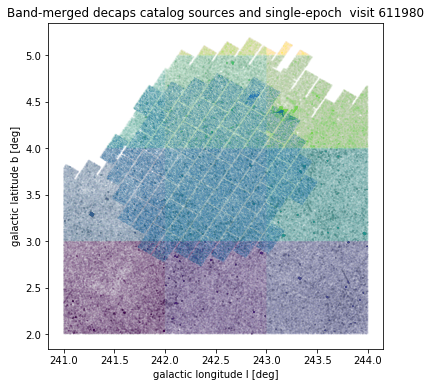

In [17]:
# plot the ra,dec of all decaps single-band sources and all decaps  band-merged tiles
# to ensure that we are covering the entire desired region .. 
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(6,6))

ax.scatter(band_coord.galactic.l.degree, band_coord.galactic.b.degree, s=0.0001,
           c = decaps_stack['flag_tile'])
ax.scatter(single_coord.galactic.l.degree, single_coord.galactic.b.degree, s = 0.0001)
ax.set_xlabel('galactic longitude l [deg]')
ax.set_ylabel('galactic latitude b [deg]')
ax.set_title('Band-merged decaps catalog sources and single-epoch  visit '+str(visit))
plt.show()
#plt.savefig('band_merged_and_single-epoch.png')

Match the coordinates, and plot the separation angle to choose the appropriate cutoff matching angle 

In [18]:
idx, d2d, d3d = single_coord.match_to_catalog_sky(band_coord)  
single_band = hstack([ccd_decaps_stack,decaps_stack[idx]], table_names=['single','band'])

(array([ 186994.,   57881.,   26639.,   16607.,   10902.,    6738.,
           4221.,    2610.,    1290.,     476.]),
 array([ 0.        ,  0.04997732,  0.09995465,  0.14993197,  0.19990929,
         0.24988661,  0.29986394,  0.34984126,  0.39981858,  0.4497959 ,
         0.49977323]),
 <a list of 10 Patch objects>)

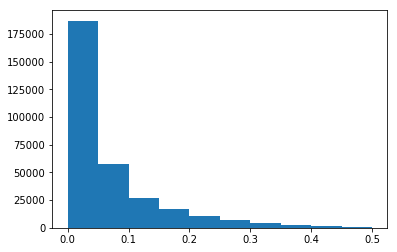

In [19]:
plt.hist(d2d.arcsec[d2d.arcsec<0.5])

In [20]:
#add a new column...
single_band['d2d_arcsec'] = d2d.arcsec

# Select those sources that have position within 0.5 arcsec ...
m = single_band['d2d_arcsec'] < 0.5 
np.sum(m)


314358

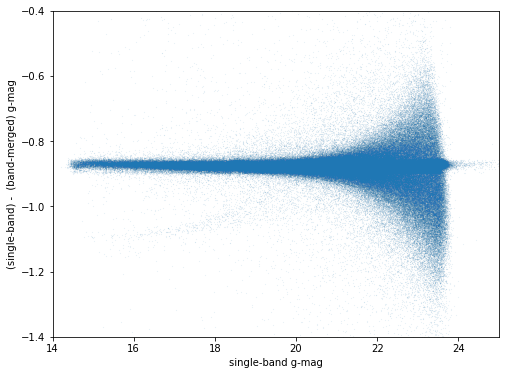

In [22]:
# Merge the two catalogs by ra,dec , plot the magnitude difference :
dmag = single_band['decaps_mag'][m] - single_band['g'][m]
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(single_band['g'][m], dmag, s=0.001)
ax.set_ylim(-1.4,-0.4)
ax.set_xlim(14,25)
ax.set_xlabel('single-band g-mag')
ax.set_ylabel('(single-band) -  (band-merged) g-mag')
plt.show()
#plt.savefig('../data_products/decaps_lsst_compare/611980/single_epoch_vs_band_merged.png')